# Lexicon Analysis

## Create Spark Session

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

24/12/18 21:36:15 WARN Utils: Your hostname, JORDAN. resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/18 21:36:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/12/18 21:36:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [14]:
df = spark.read.csv('lexicon_data/enriched_lexicon.csv', header=True)
df.show()

+-----------+-----------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------+--------------------+-------------------+
|      vocab|word_length|part_of_speech|         definitions|        sentences_eg|       derived_words|            synonyms|            antonyms|freq_of_usage|polarity|        subjectivity| subjectivity_score|
+-----------+-----------+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+--------+--------------------+-------------------+
|    berniat|          7|     kata nama|1. bertujuan (aka...|1. aku pun tidak ...|berniat;berniat-n...|maksud;tujuan;ing...|                NULL|            0|    none|         fact-driven|                0.0|
|     mundur|          6|      adjektif|1. (berjalan, ber...|1. dia mundur set...|memundurkan;kemun...|merosot;meleset;m...|           maju;maju|            0| 

## Descriptive Analysis

### Distribution of Frequency of Usage

In [15]:
df_rows = df.collect()

freq_of_use_level = {
    "rarely_used"    : 0,
    "regularly_used" : 0,
    "frequently_used": 0
}

min_freq = 99999
max_freq = -99999
for row in df_rows:
    freq_of_use = int(row[8])
    if freq_of_use < min_freq:
        min_freq = freq_of_use
    if freq_of_use > max_freq:
        max_freq = freq_of_use
        
    if freq_of_use >= 0 and freq_of_use < 15:
        freq_of_use_level["rarely_used"] = freq_of_use_level["rarely_used"] + 1
    elif freq_of_use >= 15 and freq_of_use < 30:
        freq_of_use_level["regularly_used"] = freq_of_use_level["regularly_used"] + 1
    else:
        freq_of_use_level["frequently_used"] = freq_of_use_level["frequently_used"] + 1

print(freq_of_use_level)

{'rarely_used': 210, 'regularly_used': 6, 'frequently_used': 3}


<BarContainer object of 3 artists>

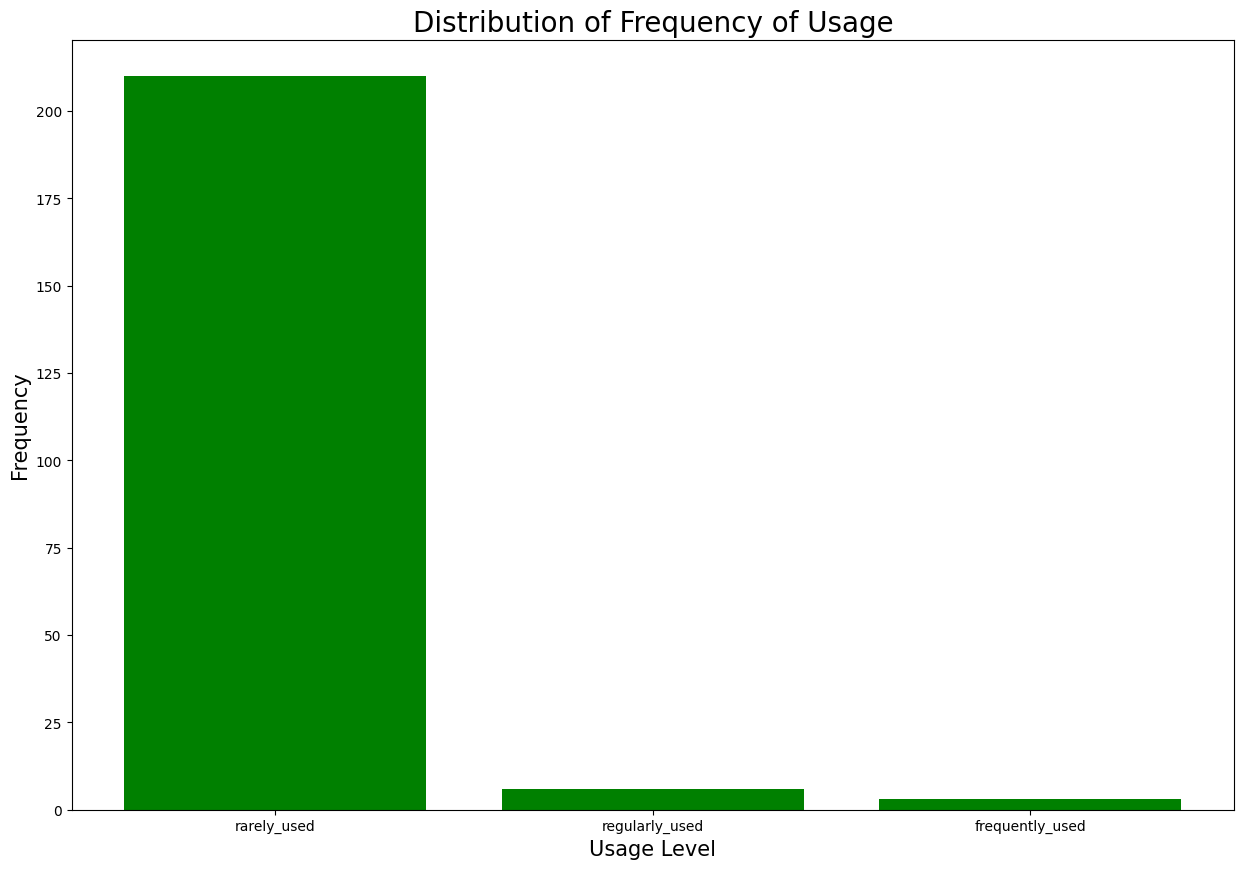

In [16]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 10))
plt.title('Distribution of Frequency of Usage', fontsize = 20)
plt.xlabel('Usage Level', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.bar(freq_of_use_level.keys(), freq_of_use_level.values(), color='g')

From the histogram above, the following insights can be concluded:

- most of the words in lexicon are rarely being used
- only a few of the words are regularly and frequently used

### Pie Chart of Frequency of Usage Distribution

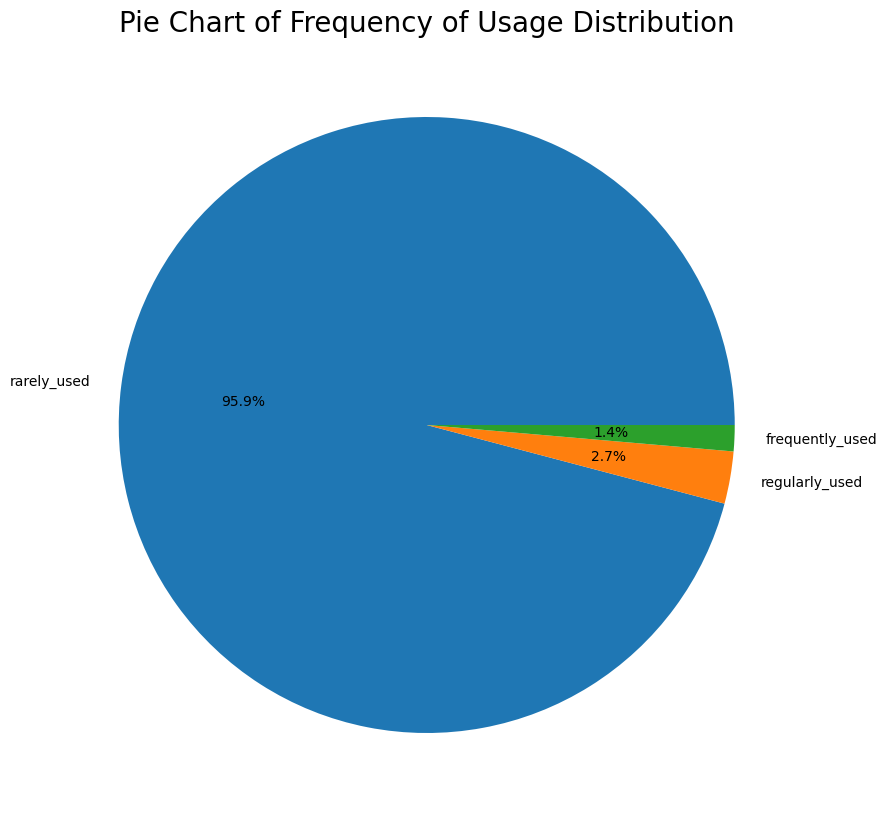

In [17]:
fig, ax = plt.subplots(figsize = (10, 10))
ax.pie(freq_of_use_level.values(), labels = freq_of_use_level.keys(), autopct='%1.1f%%')

plt.title('Pie Chart of Frequency of Usage Distribution', fontsize = 20)
plt.show()

In [18]:
print("Least Frequent Used Vocab:", df.where(df.freq_of_usage == min_freq).select('vocab', 'freq_of_usage').count())

print("Most Frequent Used Vocab:",df.where(df.freq_of_usage == max_freq).select('vocab', 'freq_of_usage').count())

Least Frequent Used Vocab: 141
Most Frequent Used Vocab: 1


### Distribution of Lengths of Words

(array([ 7., 46., 45., 36., 20., 19., 16., 12., 11.,  4.,  3.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.]),
 <BarContainer object of 11 artists>)

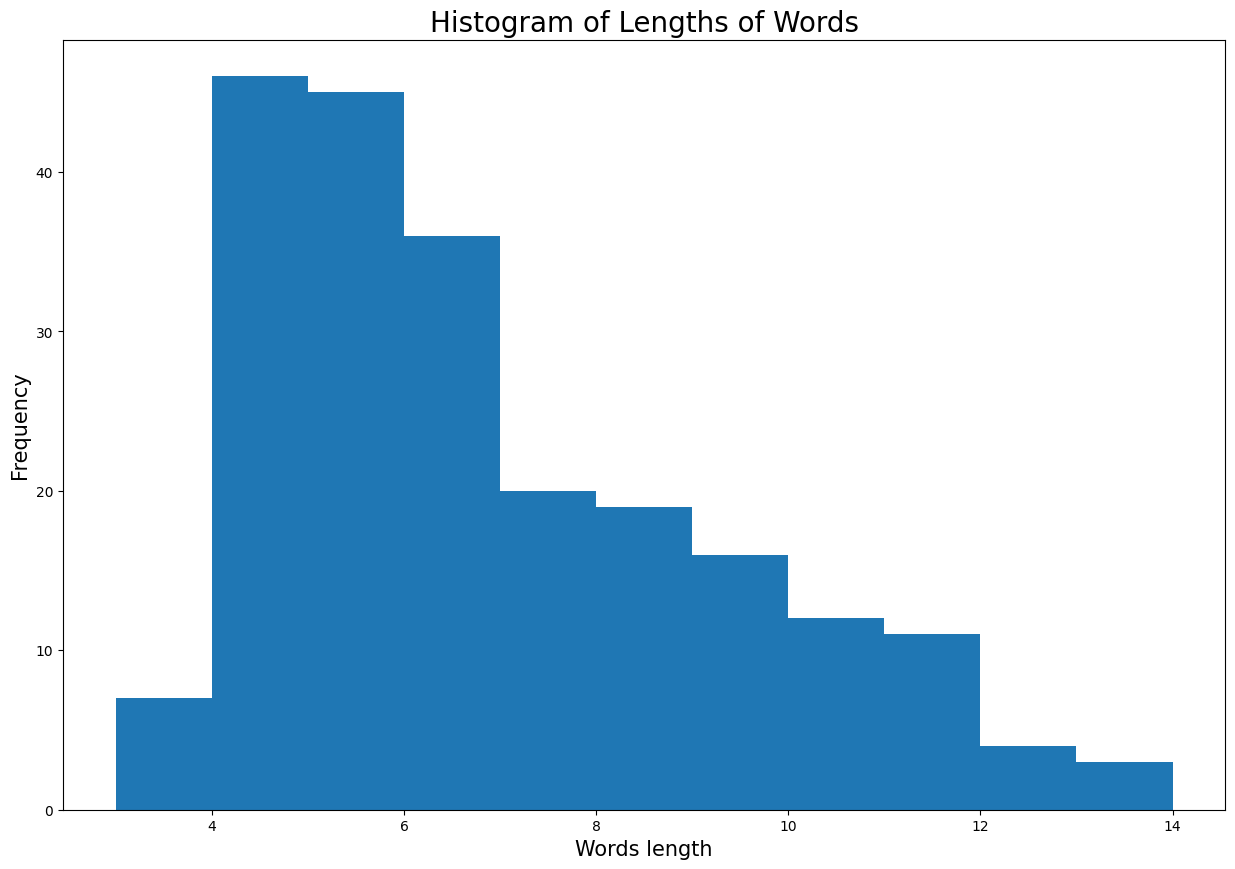

In [19]:
word_lengths = []

for row in df_rows:
    word_lengths.append(int(row[1]))

plt.figure(figsize=(15, 10))
plt.title('Histogram of Lengths of Words', fontsize = 20)
plt.xlabel('Words length', fontsize = 15)
plt.ylabel('Frequency', fontsize=15)
plt.hist(word_lengths, bins=11)

The following insights are obtained from the histogram above:

- the distribution in length of words skewed to the right.
- the distribution in length of words is concentrated at 4 - 6.
- the distribution in length of words is approximately uniform in the centre of distribution (7 - 12).

### Prefixes and Suffixes Analysis

In [20]:
prefixes = []
suffixes = []

for row in df_rows:
    vocab = row[0]
    
    if row[5] != None:
        derived_words_list = row[5].split(';')

        for i in derived_words_list:
            try:
                pref_end_index = i.index(vocab)
                prefix = i[:pref_end_index]
                suffix = i[pref_end_index + len(vocab):]

                if prefix.find('-') == -1 and prefix != None and prefix not in prefixes:
                    prefixes.append(prefix)
                if suffix.find('-') == -1 and suffix != None and suffix not in suffixes:
                    suffixes.append(suffix)
            except:
                pass

while '' in prefixes:
    prefixes.remove('')

while '' in suffixes:
    suffixes.remove('')

prefixes = [i.replace(' ', '') for i in prefixes]
suffixes = [i.replace(' ', '') for i in suffixes]
print(prefixes, suffixes)

['me', 'ke', 'ber', 'per', 'menge', 'men', 'pen', 'se', 'be', 'memper', 'ter', 'pe', 'sepe', 'berpe', 'berke', 'penge', 'berpenge', 'meng', 'peng', 'seke', 'di', 'ke', 'berse', 'berper', 'menye'] ['kan', 'an', 'i', 'nya', 'in', 'hati', 'takmahu', 'pun', '2', '3']


In [21]:
malay_prefix = ['me', 'mem', 'meng', 'memper', 'mempe', 'be', 'ber', 'ke', 'pe', 'per', 'peng', 'pen', 'se', 'di', 'anti', 'juru']
malay_suffix = ['an', 'kan', 'i', 'nya', 'pun']

def intersection(l1, l2):
    return [value for value in l1 if value in l2]
    
prefixes = intersection(malay_prefix, prefixes)
suffixes = intersection(malay_suffix, suffixes)
print("Prefixes Existed: " + str(prefixes) + "\nSuffixes Existed: " + str(suffixes))

Prefixes Existed: ['me', 'meng', 'memper', 'be', 'ber', 'ke', 'pe', 'per', 'peng', 'pen', 'se', 'di']
Suffixes Existed: ['an', 'kan', 'i', 'nya', 'pun']


In [22]:
total_prefix_count = 0
total_suffix_count = 0

for row in df_rows:
    vocab = row[0]

    if row[5] != None:
        derived_words_list = row[5].split(';')

    for i in derived_words_list:
        try:
            pref_end_index = i.index(vocab)
            prefix = i[:pref_end_index]
            suffix = i[pref_end_index + len(vocab):]

            if prefix in prefixes:
                total_prefix_count += 1
            if suffix in suffixes:
                total_suffix_count += 1
        except:
            pass

print(
    "Total Prefix Count: " + str(total_prefix_count) +
    "\nTotal Suffix Count: " + str(total_suffix_count)
)

Total Prefix Count: 163
Total Suffix Count: 113


<BarContainer object of 2 artists>

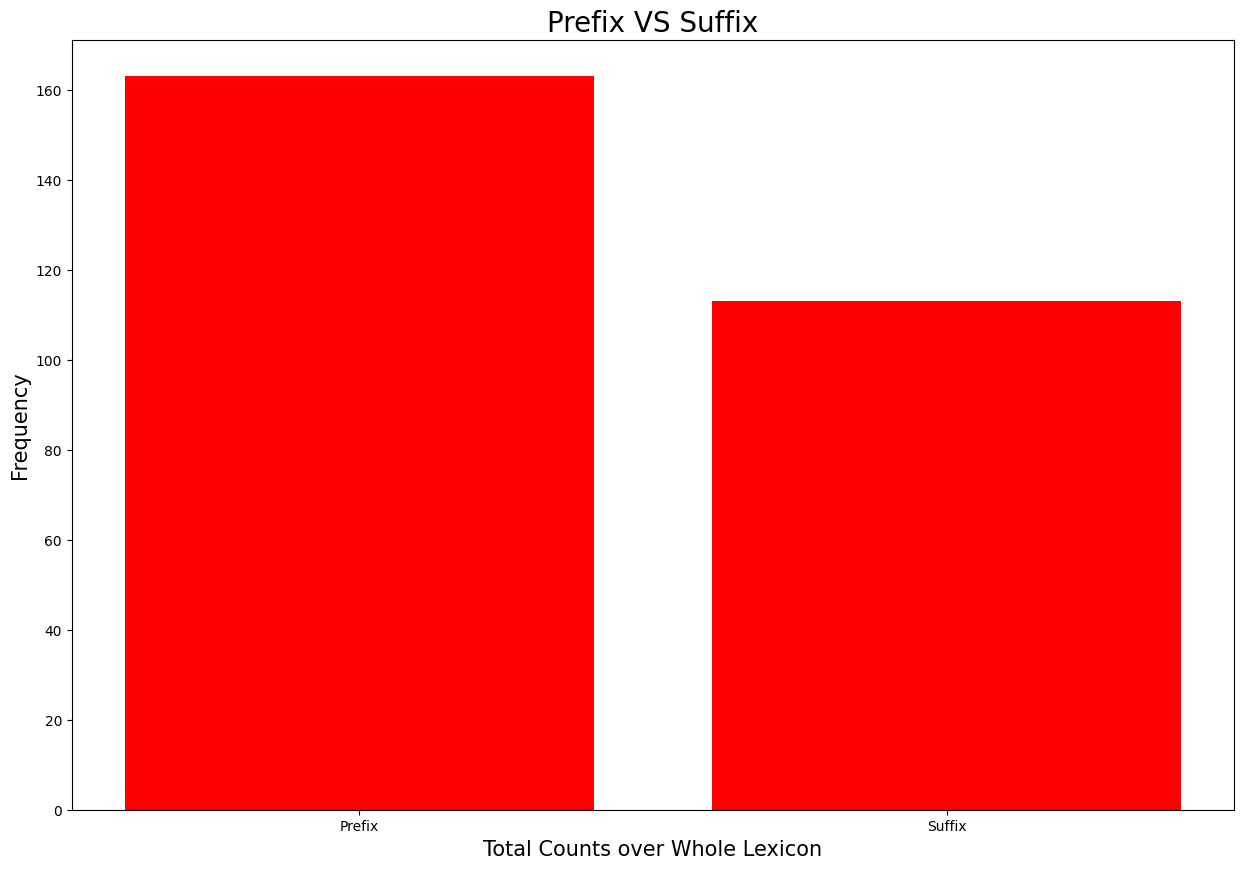

In [23]:
plt.figure(figsize=(15, 10))
plt.title('Prefix VS Suffix', fontsize=20)
plt.xlabel('Total Counts over Whole Lexicon', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.bar(['Prefix', 'Suffix'], [total_prefix_count, total_suffix_count], color='r')

In here, we can simply conclude that **the usage of prefix is more frequent than the usage of suffix**.

### Relationship between Prefixes and Suffixes

In [24]:
prefix_per_word = []
suffix_per_word = []

for row in df_rows:
    vocab = row[0]
    temp_pref_quant = 0
    temp_suff_quant = 0

    if row[5] != None:
        derived_words_list = row[5].split(';')

    for i in derived_words_list:
        try:
            pref_end_index = i.index(vocab)
            prefix = i[:pref_end_index]
            suffix = i[pref_end_index + len(vocab):]

            if prefix in prefixes:
                temp_pref_quant += 1
            if suffix in suffixes:
                temp_suff_quant += 1
        except:
            pass

    prefix_per_word.append(temp_pref_quant)
    suffix_per_word.append(temp_suff_quant)

print(
    "Prefix Count Per Word: " + str(prefix_per_word) +
    "\nSuffix Count Per Word: " + str(suffix_per_word)
)

Prefix Count Per Word: [0, 2, 2, 1, 3, 2, 4, 5, 2, 4, 1, 1, 0, 0, 3, 0, 1, 0, 1, 1, 2, 2, 1, 1, 0, 0, 1, 0, 2, 0, 1, 3, 2, 0, 0, 1, 1, 4, 0, 2, 1, 0, 1, 0, 2, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 2, 0, 0, 2, 4, 0, 0, 1, 0, 3, 0, 0, 1, 0, 0, 0, 0, 4, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 4, 0, 0, 1, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 1, 4, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 1, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 6, 0, 0, 0, 0, 0, 0, 3, 2, 0]
Suffix Count Per Word: [0, 2, 1, 1, 3, 0, 2, 1, 0, 4, 1, 1, 0, 0, 1, 0, 5, 0, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 3, 1, 0, 0, 2, 0, 3, 1, 1, 1, 0, 0, 0, 1, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 2, 6, 0, 0, 1

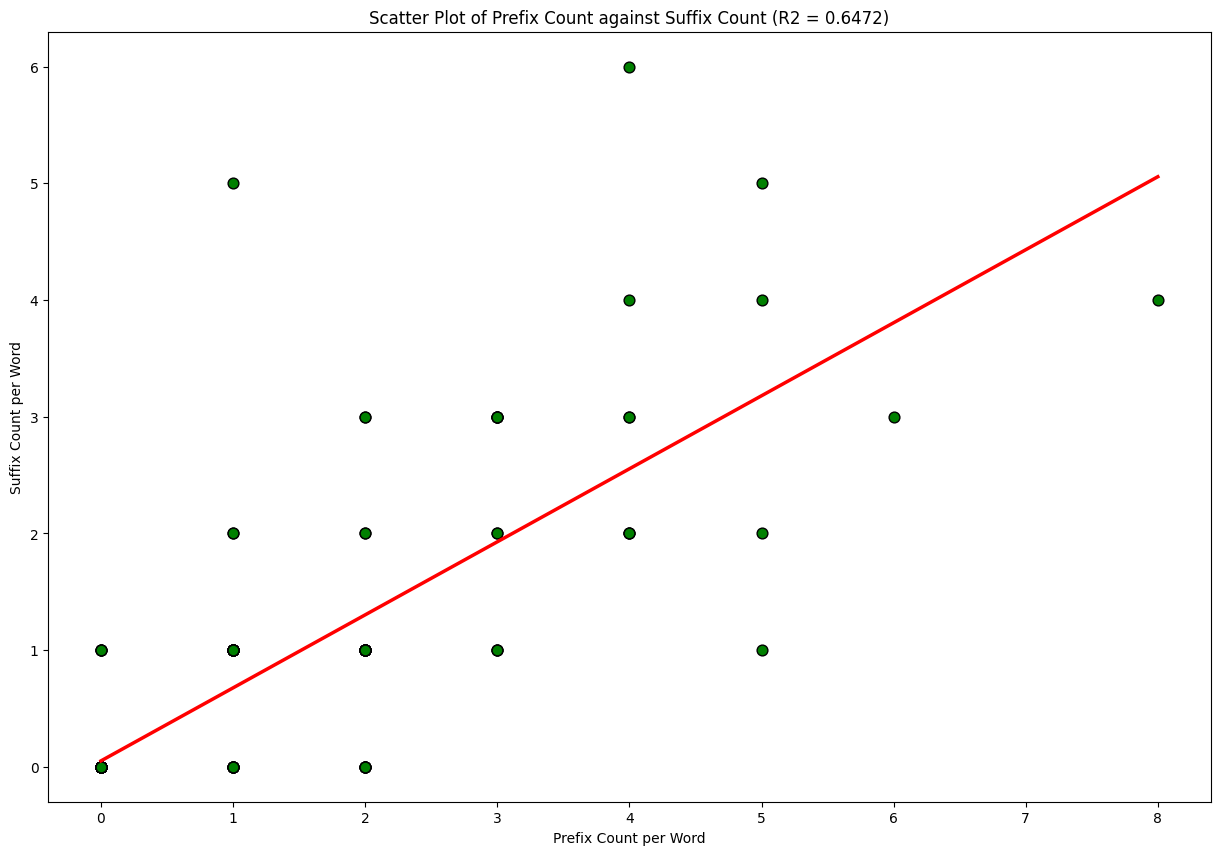

In [25]:
import numpy as np
import scipy

r = scipy.stats.linregress(prefix_per_word, suffix_per_word)[2]

fig, ax = plt.subplots(figsize=(15, 10))
plt.title(f'Scatter Plot of Prefix Count against Suffix Count (R2 = {r**2:.4f})')
plt.xlabel('Prefix Count per Word')
plt.ylabel('Suffix Count per Word')
ax.scatter(prefix_per_word, suffix_per_word, s=60, color='g', edgecolors='k')

b1, b0 = np.polyfit(prefix_per_word, suffix_per_word, deg=1)
xseq = np.linspace(0, 8, num = 100)


ax.plot(xseq, b0 + b1 * xseq, color='r', lw=2.5)

The regression line by plotting prefix count per word againt suffix count per word gives a coefficient of determination of 0.6479 ($r^{2} = 0.6479$). This indicates that the appearance of possible prefix and suffix in one single word has a **relatively strong** association.

## Synonyms Relationship Network

In [26]:
import networkx as nx

ng = nx.Graph()

vocabs = []
for row in df_rows:
    ng.add_node(row[0])
    vocabs.append(row[0])

for k in range(len(df_rows)):
    if df_rows[k][6] != None:
        synonyms = df_rows[k][6].split(';')
    
        for i in range(len(synonyms)):
            for j in range(len(vocabs)):
                if synonyms[i] == vocabs[j] and i != j:
                    ng.add_edge(df_rows[k][0], vocabs[j])
                    break

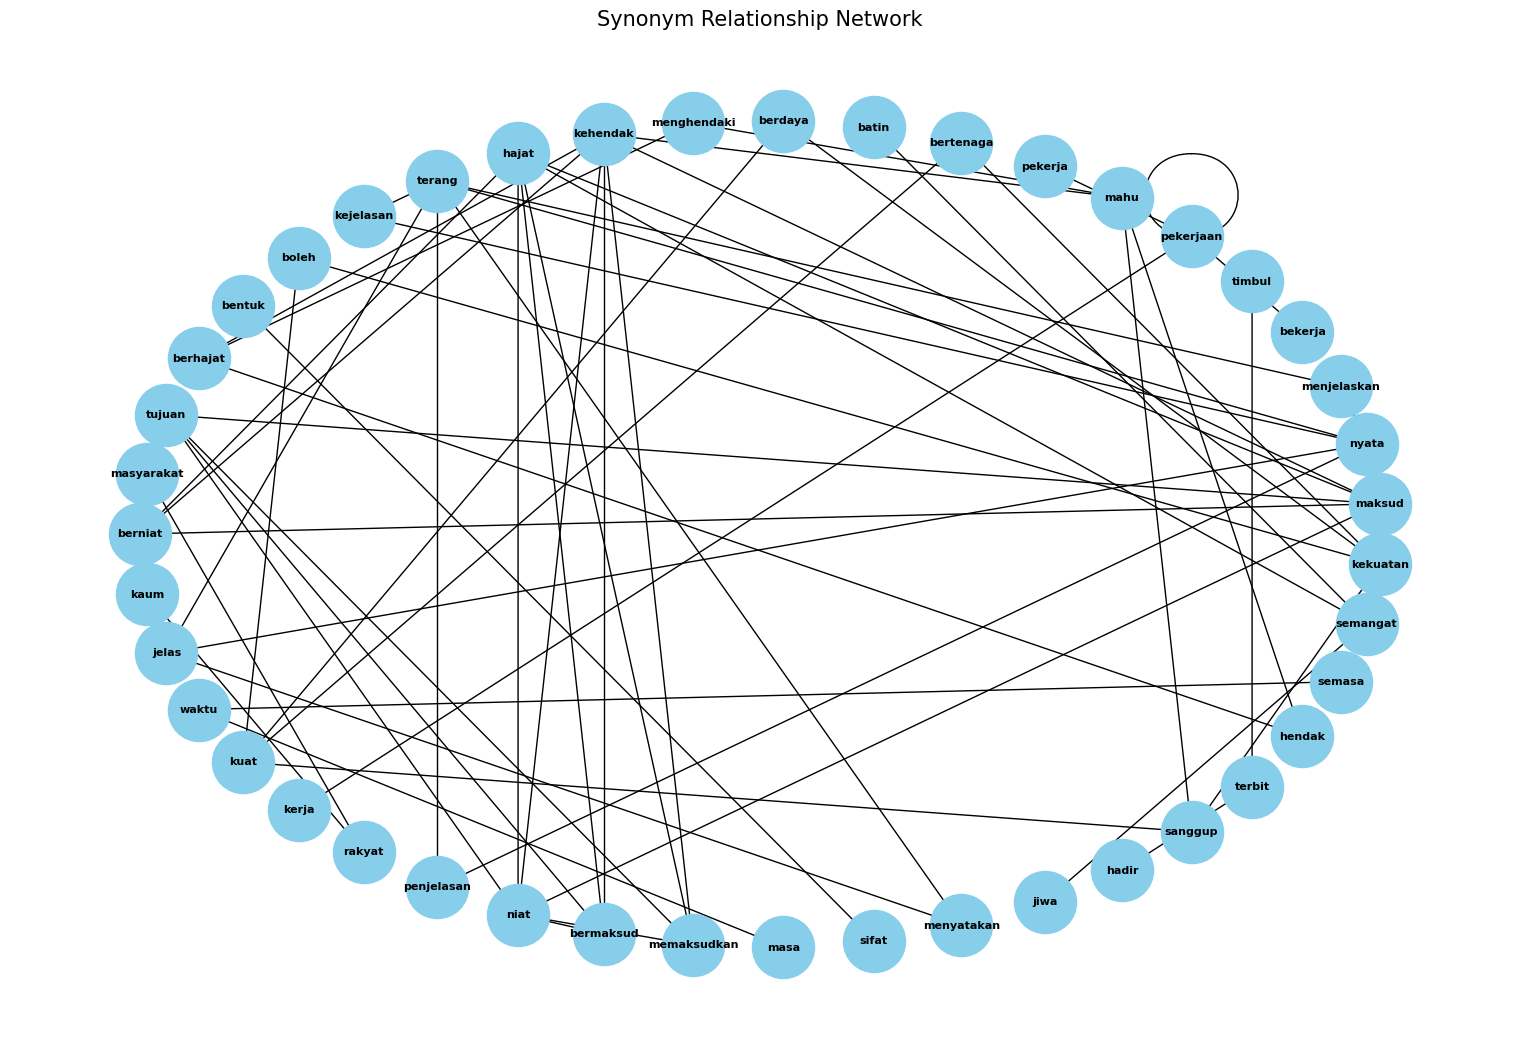

In [27]:
isolated_nodes = [node for node, degree in dict(ng.degree()).items() if degree == 0]
ng.remove_nodes_from(isolated_nodes)

plt.figure(figsize=(15,10))
pos = nx.shell_layout(ng)
nx.draw(
    ng, pos, with_labels=True, node_color="skyblue", node_size=2000, font_size=8, font_color="black", font_weight="bold"
)
plt.title("Synonym Relationship Network", fontsize=15)
plt.show()

### Words' Polarity Analysis

<BarContainer object of 3 artists>

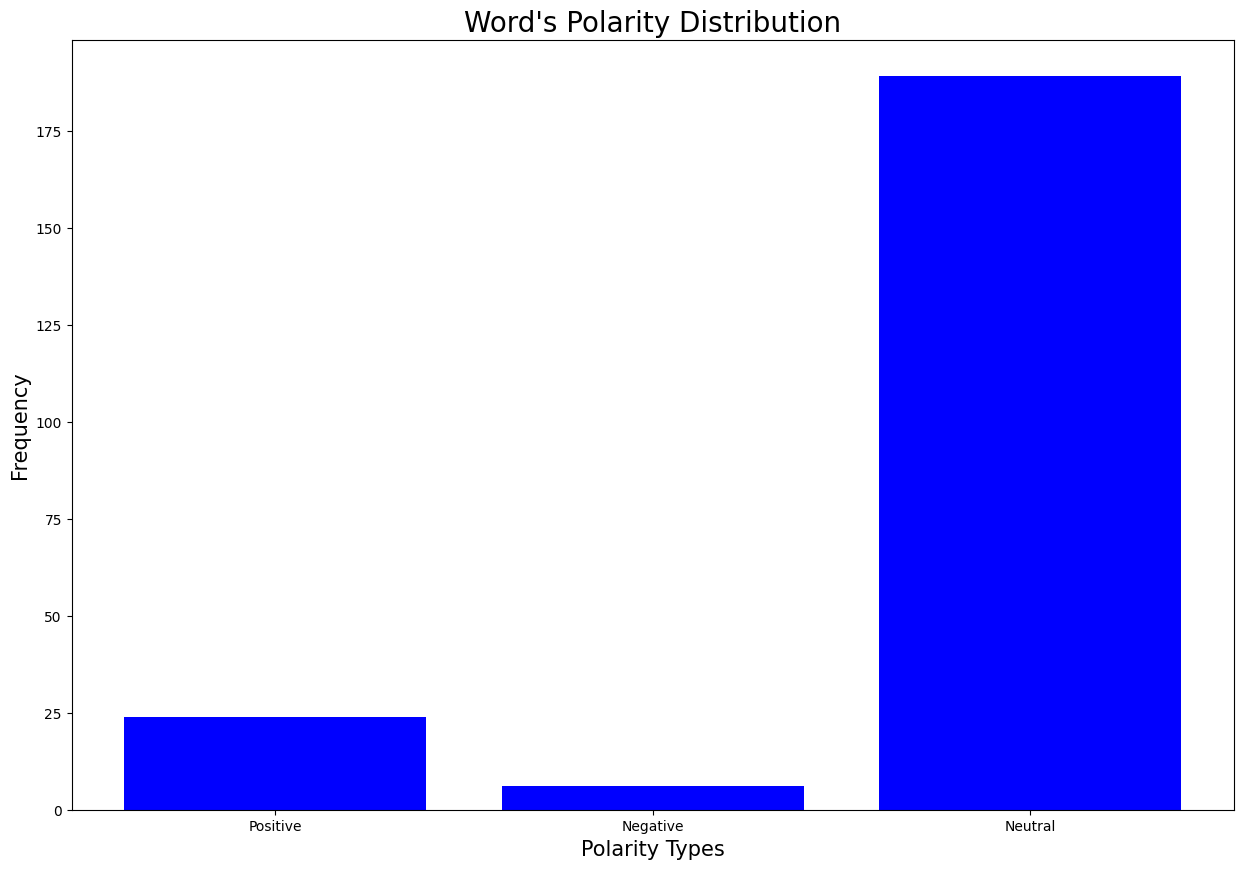

In [28]:
total_positive_count = 0
total_negative_count = 0
total_neutral_count = 0

for row in df_rows:
    polarity = row[9]

    if polarity == 'positive':
        total_positive_count += 1
    elif polarity == 'negative':
        total_negative_count += 1
    elif polarity == 'none':
        total_neutral_count += 1

plt.figure(figsize=(15, 10))
plt.title("Word's Polarity Distribution", fontsize=20)
plt.xlabel('Polarity Types', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.bar(['Positive', 'Negative', 'Neutral'], [total_positive_count, total_negative_count, total_neutral_count], color='b')

From the data scrapped, it is found that most of the words are in neutral polarity. This may be caused by the reason where **most of the words are not adjectives** (adjectives have more tendency of being positive or negative).

### Distribution of Part of Speech

In [29]:
df.select('part_of_speech').distinct().show()

+--------------+
|part_of_speech|
+--------------+
|       adverba|
|      adjektif|
|     kata nama|
|    kata tugas|
|    kata kerja|
|          NULL|
+--------------+



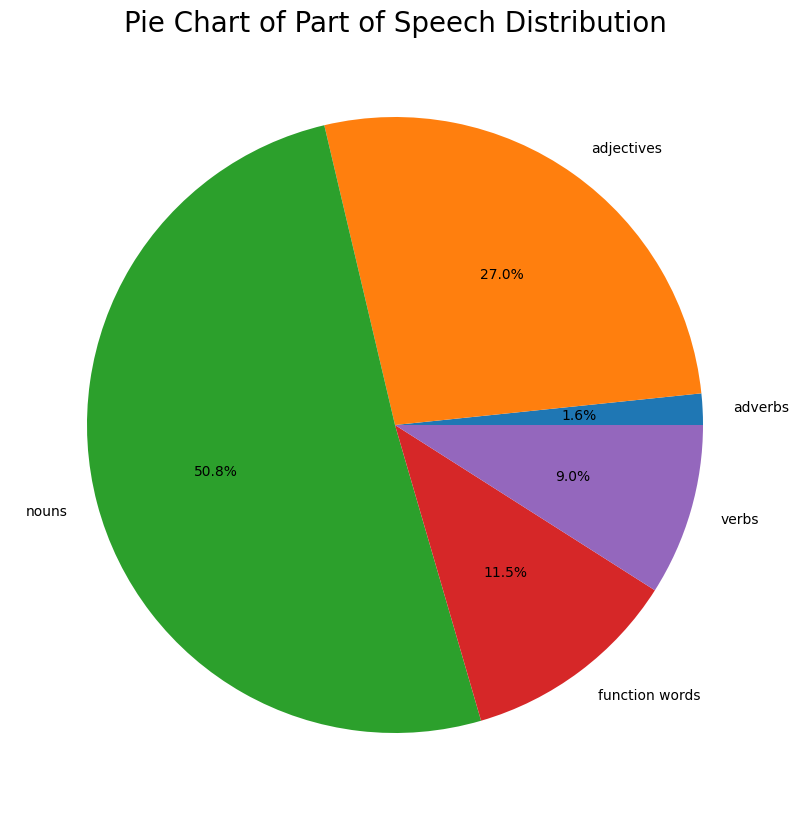

In [30]:
total_adverb_count = 0
total_adjective_count = 0
total_nouns_count = 0
total_func_words_count = 0
total_verbs_count = 0

for row in df_rows:
    part_of_speech = row[2]

    if part_of_speech == 'adverba':
        total_adverb_count += 1
    elif part_of_speech == 'adjektif':
        total_adjective_count += 1
    elif part_of_speech == 'kata nama':
        total_nouns_count += 1
    elif part_of_speech == 'kata tugas':
        total_func_words_count += 1
    elif part_of_speech == 'kata kerja':
        total_verbs_count += 1

fig, ax = plt.subplots(figsize = (10, 10))
ax.pie([total_adverb_count, total_adjective_count, total_nouns_count, total_func_words_count, total_verbs_count], labels = ['adverbs', 'adjectives', 'nouns', 'function words', 'verbs'], autopct='%1.1f%%')

plt.title('Pie Chart of Part of Speech Distribution', fontsize = 20)
plt.show()

In here, we found that

1. the most part of speech: **nouns**.
2. the least part of speech: **adverbs**.
3. **function words** and **verbs** has similar contribution.

### Study about Correlation of Word Lengths and Frequency of Usage

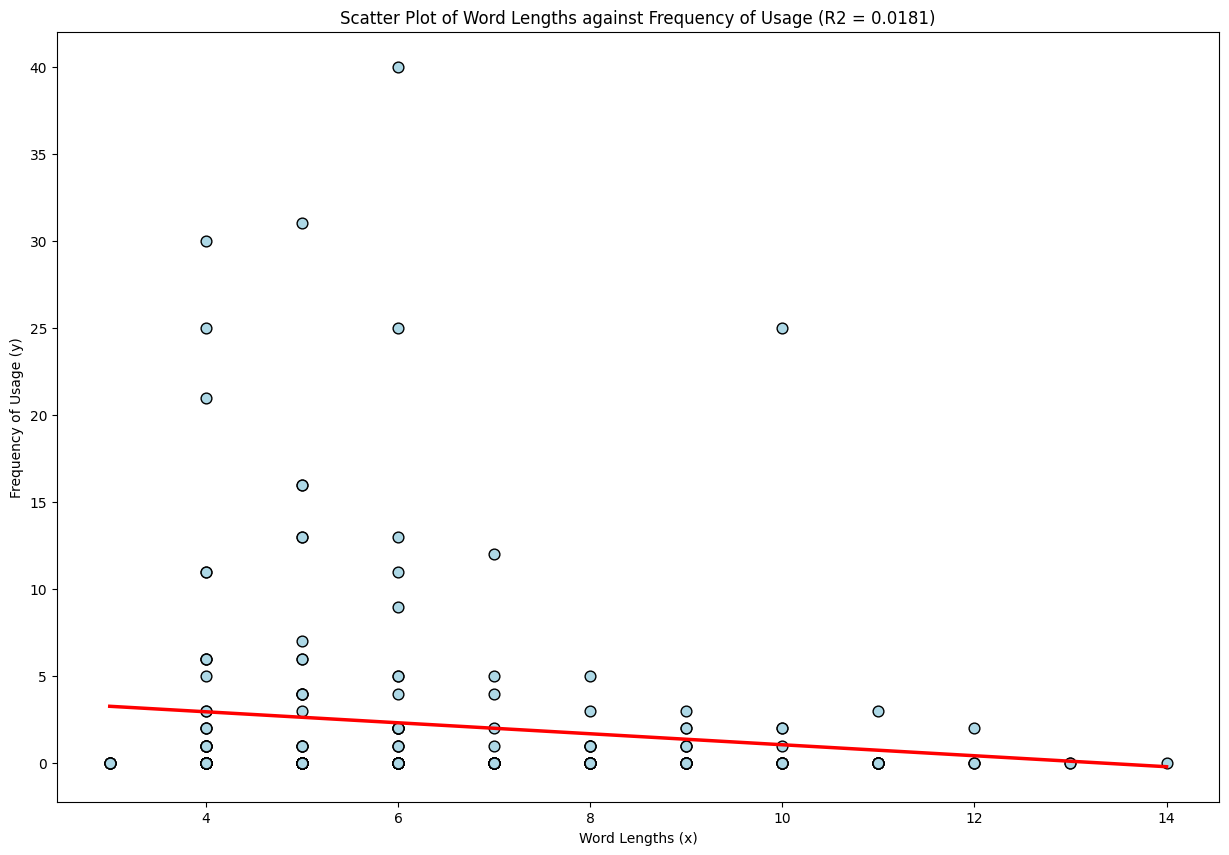

In [31]:
freq_of_use = []

for row in df_rows:
    freq_of_use.append(int(row[8]))

r = scipy.stats.linregress(word_lengths, freq_of_use)[2]

fig, ax = plt.subplots(figsize=(15, 10))
plt.title(f'Scatter Plot of Word Lengths against Frequency of Usage (R2 = {r**2:.4f})')
plt.xlabel('Word Lengths (x)')
plt.ylabel('Frequency of Usage (y)')
ax.scatter(word_lengths, freq_of_use, s=60, color='lightblue', edgecolors='k')

b1, b0 = np.polyfit(word_lengths, freq_of_use, deg=1)
xseq = np.linspace(3, 14, num = 100)

ax.plot(xseq, b0 + b1 * xseq, color='r', lw=2.5)

### Statistics about Subjectiivty Scores

In [32]:
from python_script.statistics_calc import *
from pyspark.sql import Row
import pandas as pd

subjectivity_scores = []

for row in df_rows:
    subjectivity_scores.append(float(row[-1]))

label_list = ['N', 'mean', 'variance', 'standard deviation', 'standard error', 'range', 'coefficient of range', 'confidence interval']
value_list = [len(subjectivity_scores), mean(subjectivity_scores), var(subjectivity_scores), stddev(subjectivity_scores), stderr(subjectivity_scores),
              val_range(subjectivity_scores), cor(subjectivity_scores), conf_int(subjectivity_scores, 0.01)]

pd.DataFrame({
    'Statistic': label_list,
    'Value': value_list
})

for i in range(len(label_list)):
    if i != len(label_list) - 1:
        print(f'{label_list[i]:>20} : {value_list[i]:.4f}')
    else:
        print(f'{label_list[i]:>20} : {value_list[i]}')

                   N : 219.0000
                mean : 0.2972
            variance : 0.0504
  standard deviation : 0.2246
      standard error : 0.0152
               range : 1.0000
coefficient of range : 1.0000
 confidence interval : (0.2619, 0.3325)


## Intrinsic Evaluation

### Lexicon Coverage

In [4]:
data_file = f'google_books_data/gb_data_{int(input()):04d}.csv'

gb_df = spark.read.csv(data_file, header=True)
gb_df.show()

 1


+------------+-----------+--------------+--------------------+--------------------+--------------------+--------------------+--------+-------------+--------+--------------------+-------------------+
|       vocab|word_length|part_of_speech|         definitions|        sentences_eg|       derived_words|            synonyms|antonyms|freq_of_usage|polarity|        subjectivity| subjectivity_score|
+------------+-----------+--------------+--------------------+--------------------+--------------------+--------------------+--------+-------------+--------+--------------------+-------------------+
|       asing|          5|          NULL|1. berlainan, ter...|1. banyak bangsa ...|                NULL|                NULL|    NULL|            2|negative|partially fact-dr...|            0.46875|
|        atas|          4|          NULL|1 tempat atau bah...|1. atas bumbung. ...|                NULL|                NULL|    NULL|            1|positive|partially fact-dr...|               0.25|
|    

In [5]:
from sklearn.metrics import *

base_words = df.select('vocab', 'definitions')
gb_words = gb_df.select('vocab', 'definitions')

In [6]:
from python_script.metrics_calc import *

coverage_mark = coverage(base_words, gb_words)
print(coverage_mark)
print('or in percentage,', f'{coverage_mark*100:.2f}%')

0.0410958904109589
or in percentage, 4.11%


### Lexicon Accuracy

_exact annotation accuracy_

In [7]:
anno_acc = annotation_accuracy_exact(base_words, gb_words)
print(anno_acc)
print('or in percentage,', f'{anno_acc*100:.2f}%')

0.0
or in percentage, 0.00%


_levenshtein distance similarity_

In [8]:
lev_simi = similarity_levenshtein(base_words, gb_words)
print(lev_simi)
print('or in percentage,', f'{lev_simi:.2f}%')

9.322321935754918
or in percentage, 9.32%


### Extrinsic Evaluation

_Polarity VS Subjectivity **with polynomial regression**_

In [9]:
from python_script.sentiment import *

base_words = df.select('vocab', 'subjectivity_score')
gb_words = gb_df.select('vocab', 'subjectivity_score')

base_rows = base_words.collect()
gb_rows = gb_words.collect()

base_polarity = []
base_subjectivity = []
for row in base_rows:
    vocab = row[0]
    subjectivity = row[1]

    trans_vocab = translateFromMyToEn(vocab)

    polarity = getPolarityValue(trans_vocab)

    base_polarity.append(polarity)
    base_subjectivity.append(float(subjectivity))

gb_polarity = []
gb_subjectivity = []
for row in gb_rows:
    vocab = row[0]
    subjectivity = row[1]

    trans_vocab = translateFromMyToEn(vocab)

    polarity = getPolarityValue(trans_vocab)

    gb_polarity.append(polarity)
    gb_subjectivity.append(float(subjectivity))

Enter the degree of polynomial regression (positive integers) >>  4


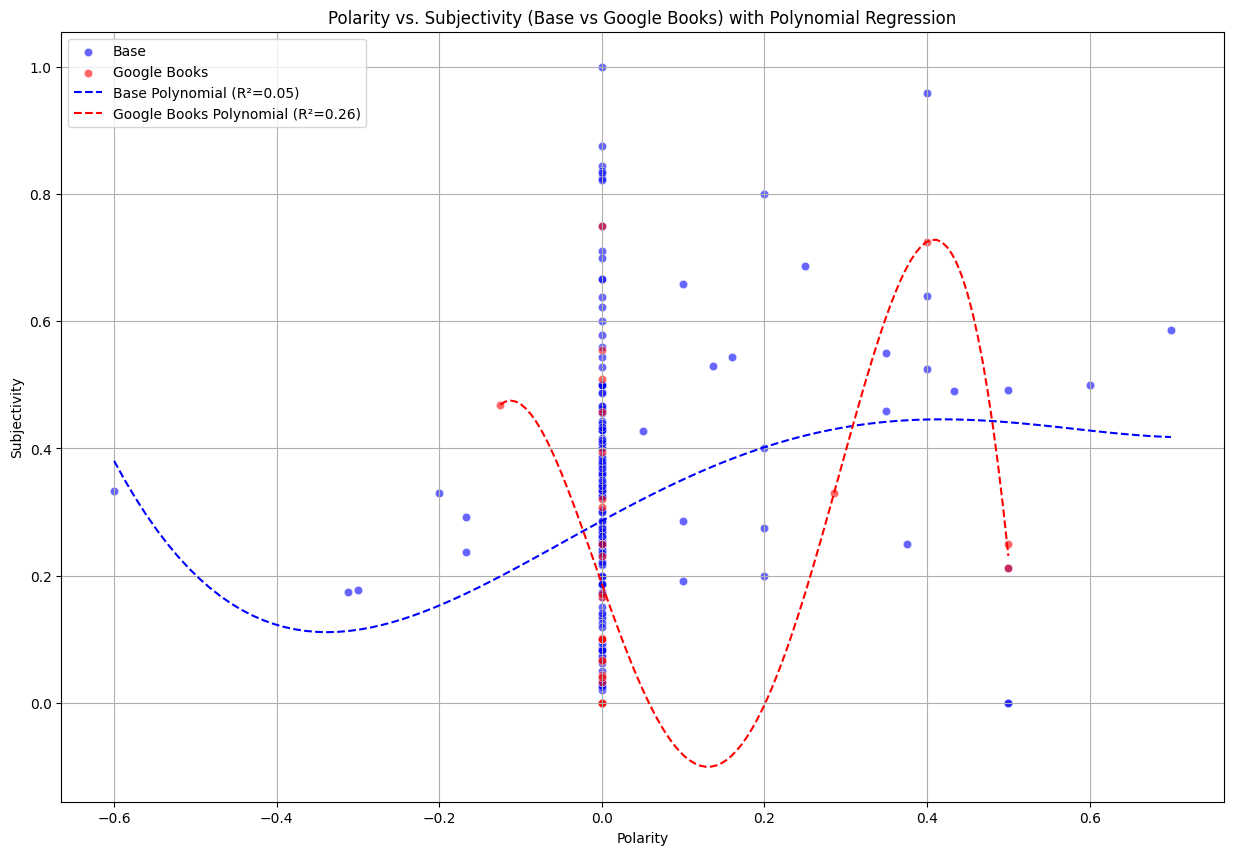

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import linregress

max_len = max(len(base_polarity), len(gb_polarity))

base_polarity += [None] * (max_len - len(base_polarity))
base_subjectivity += [None] * (max_len - len(base_subjectivity))
gb_polarity += [None] * (max_len - len(gb_polarity))
gb_subjectivity += [None] * (max_len - len(gb_subjectivity))

data = {
    'base_polarity': base_polarity,
    'base_subjectivity': base_subjectivity,
    'gb_polarity': gb_polarity,
    'gb_subjectivity': gb_subjectivity
}

df = pd.DataFrame(data)

plt.figure(figsize=(15, 10))
sns.scatterplot(x='base_polarity', y='base_subjectivity', data=df, color='blue', label='Base', alpha=0.6)
sns.scatterplot(x='gb_polarity', y='gb_subjectivity', data=df, color='red', label='Google Books', alpha=0.6)

degree = int(input('Enter the degree of polynomial regression (positive integers) >> '))
base_non_nan = df.dropna(subset=['base_polarity', 'base_subjectivity'])
if not base_non_nan.empty:
    poly_base = np.polyfit(base_non_nan['base_polarity'], base_non_nan['base_subjectivity'], degree)
    poly_base_func = np.poly1d(poly_base)

    x_base_poly = np.linspace(base_non_nan['base_polarity'].min(), base_non_nan['base_polarity'].max(), 100)
    y_base_poly = poly_base_func(x_base_poly)
    
    y_base_pred = poly_base_func(base_non_nan['base_polarity'])
    r2_base = r2_score(base_non_nan['base_subjectivity'], y_base_pred)
    
    plt.plot(x_base_poly, y_base_poly, color='blue', linestyle='--', label=f'Base Polynomial (R²={r2_base:.2f})')

gb_non_nan = df.dropna(subset=['gb_polarity', 'gb_subjectivity'])
if not gb_non_nan.empty:
    poly_gb = np.polyfit(gb_non_nan['gb_polarity'], gb_non_nan['gb_subjectivity'], degree)
    poly_gb_func = np.poly1d(poly_gb)

    x_gb_poly = np.linspace(gb_non_nan['gb_polarity'].min(), gb_non_nan['gb_polarity'].max(), 100)
    y_gb_poly = poly_gb_func(x_gb_poly)
    
    y_gb_pred = poly_gb_func(gb_non_nan['gb_polarity'])
    r2_gb = r2_score(gb_non_nan['gb_subjectivity'], y_gb_pred)
    
    plt.plot(x_gb_poly, y_gb_poly, color='red', linestyle='--', label=f'Google Books Polynomial (R²={r2_gb:.2f})')

plt.title('Polarity vs. Subjectivity (Base vs Google Books) with Polynomial Regression')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.legend()
plt.grid(True)

plt.show()

In here, we can conclude the following insights:

1. Regression model may not be suitable to represent the relationship between polarity and subjectivity.
2. In other word, there is no polynomial relationship between polarity and subjectivity.
3. The most suitable polynomial degree is 3.
4. As the polynomial degree get larger than 3, i.e. $n > 3, \forall n \in \mathbb{Z}$, it will cause the problem of invalid prediction. (The value predicted will exceed the acceptable range of subjectivity ($0 \leqslant$ subjectivity $ \leqslant 1$))

_Polarity VS Subjectivity **with box plots**_

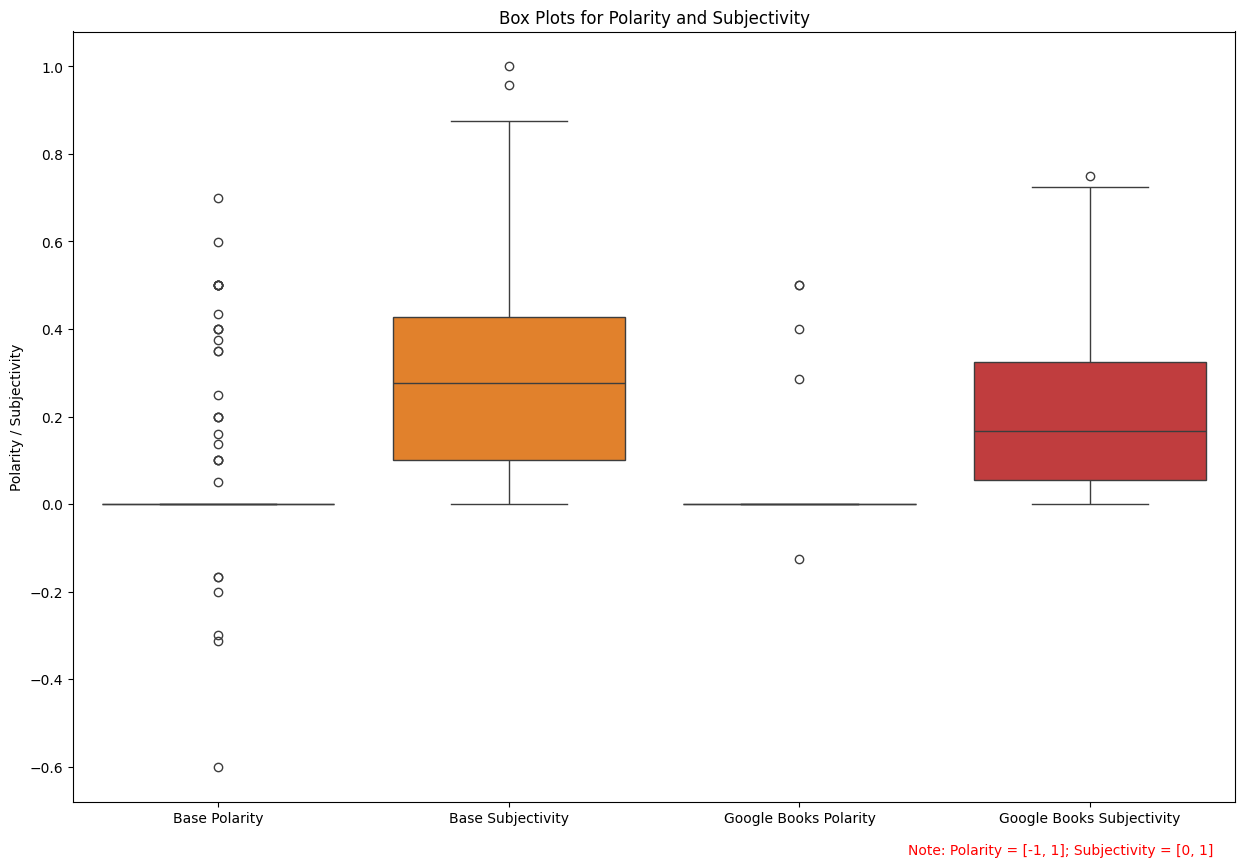

In [47]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)

plt.title('Box Plots for Polarity and Subjectivity')
plt.ylabel('Polarity / Subjectivity')
plt.xticks([0, 1, 2, 3], ['Base Polarity', 'Base Subjectivity', 'Google Books Polarity', 'Google Books Subjectivity'])
plt.text(2.9, -0.8, 'Note: Polarity = [-1, 1]; Subjectivity = [0, 1]', fontsize=10, ha='center', color='red')

plt.show()

In [32]:
spark.stop()